# Time Series Analysis

M. Juric (2019), with materials from Richards, Connolly, and Ivezic; Chapter 10. in the textbook.

# Packages

- make sure that `pymc`, `astroML`, and `gatspy` are installed:  
```
conda install -c defaults -c astropy astroML
conda install -c defaults -c conda-forge pymc3 gatspy
```

# Time Series Analysis

Time series analysis is, in many ways, very similar to one-dimensional model fitting and regression analysis (which is discussed in the textbook), except that we replace $x$ with $t$.

There is a broad range of variability signatures that we want to be aware of. From transient events to periodic variables to stochastic sources.

<img src="figures/flare.png" style="float: left; width: 30%; margin-right: 1%;"> <img src="figures/cepheid.png" style="float: left; width: 30%; margin-right: 1%;"> <img src="figures/eclipsing.png" style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">

## Goals

When dealing with time series data, the first thing that we want to know is if the system that we are studying is even variable (otherwise, there is no point doing time series analysis!).

If we find that our source *is* variable, then our time-series analysis has two main goals:
1. Characterize the temporal correlation between different values of $y$ (i.e., characterize the "light curve").  For example by learning the parameters for a model.
2. Predict future values of $y$.

## Is the Object Variable?

If the errors are known and Gaussian, we can simply compute $\chi^2$ for the data ***assuming the model where the object is not variable***, and see how likely that $\chi^2$ is.

If we assume the object is **not** variable (i.e., $y(t) = y_0$), the $\chi^2$ will be equal to:

* $\chi^2_{\rm dof}=\frac{1}{N} \sum_j \left(\frac{y_j - y_0}{\sigma}\right)^2$.

If this model is true, then:

* $\chi^2_{\rm dof}$ has  expectation value of 1 and std dev  of $\sqrt\frac{2}{N}$

(where $N$ is the number of degrees of freedom, which can be approximated with the number of datapoints when that number is much larger than the number of parameters; see the lectures on Maximum Likelihood and discussion of $\chi^2$).

If there is variability, then:
- $\chi^2_{\rm dof}$ will be larger than 1. Is this discrepancy just luck of the draw, or an indication that the object is variable?
- We can assess that, as we know that $\chi^2_{dof}$ is drawn from a normal distribution (for large $N$). E.g., probability that $\chi^2_{\rm dof}>1 + 3 \sqrt{2/N}$  is about 1 in 1000 (i.e., $>3\sigma$ above 1)

Given a chosen acceptable false-positive rate (i.e., even without variability, 1 times in X we will observe a $\chi^2_{\rm dof}$ above the chosen threshold) then we can claim we detected variability. E.g., for $3\sigma$ threshold, like above, approximately $X=1000$.

This is the best that we can do under the assumption of the null hypothesis of no variability.  If instead we know the model (not limited to periodic variability), then we can perform a [**"matched filter"**](https://en.wikipedia.org/wiki/Matched_filter) analysis and improve upon this (i.e., we can positively identify lower-amplitude variability).

Imagine we have a sinusoidal variable signal

$$y(t) = y_0 + A \sin(\omega t)$$

that's measured with homoscedastic errors, $\sigma$. The variance of this signal is $V = \sigma^2 + A^2/2$, so we expect the $\chi^2_{\rm dof}$ for a model with no variability to be:

* $\chi^2_{\rm dof}=\frac{1}{N} \sum_j \left(\frac{y_j - y_0}{\sigma}\right)^2 \sim V/\sigma^2$.


If we choose $3 \sigma$ (1:1000 false positive rate) as the threshold, we find that the minimum detectable amplitude is:

$$A > \left( \frac{72}{N} \right)^\frac{1}{4} \sigma \approx 2.9 \sigma N^{-{1 \over 4}}$$

which follows from equating $V/\sigma^2=1 + 3 \sqrt{2/N}$, expanding $V$, and solving for $A$.

For $N=100$ data points, the minimum detectable amplitude is $A=0.92\sigma$

For $N=1000$, $A = 0.52\sigma$ 

That is, if we have enough data points, we can actually detect variability whose amplitude is smaller than the uncertainty in the measurements.

## Parameter Estimation, Model Selection, and Classification

Time series analysis can be conducted in either the time domain or the frequency domain.  We'll first start with a discussion of the time domain.

Generally, we can fit a model to $N$ data points $(t_i,y_i)$:

$$y_i(t_i) = \sum_{m=1}^M \beta_m \rm{T}_m(t_i|\theta_m) + \epsilon_i,$$

where $\theta_m$ are the model parameters, the functions $\rm{T}_m$ do not necessarily need to be periodic and $t_i$ does not need to be evenly sampled.

So, for example, if we have:

$$y_i(t_i) = a \sin(\omega_0 t_i) + b \cos (\omega_1 t_i),$$

then $\sin = \rm{T}_0$, $\cos = \rm{T}_1$, $a=\beta_0$, $b=\beta_1$, $\omega_0=\theta_0$, and $\omega_1 = \theta_1$.

Determining whether a variable model is favored over a non-variable model is the same as we have dealt with previously and can also be approached using the AIC, BIC, or Bayesian odds ratio.  Once the model parameters, $\theta_m$ have been determined, we can also apply supervised or unsupervised classification methods to gain further insight (we'll talk about these next week).

Common deterministic models include

$$\rm{T}(t) = \sin(\omega t)$$

and

$$\rm{T}(t) = \exp(-\alpha t),$$

where the frequency, $\omega$, and decay rate, $\alpha$, are parameters to be estimated from the data.

We will also explore a so-called "chirp" signal with

$$\rm{T}(t) = \sin(\phi + \omega t + \alpha t^2) =  \sin\left(\phi + t ( \omega + \alpha t) \right).$$

(another way of thinking of a chirp is that the *frequency varies with time*; $\omega_{\rm instantaneous} = \omega + \alpha t$)

## Fourier Analysis ($\S$ 10.2)

Fourier Analysis has the potential to be the subject for an entire class as opposed to part of a single lecture. 

The code below demostrates an application that you are surely familiar with: reconstruction of a complicated signal by summation of simpler trig functions.


In [32]:
def fig_10_1():
    # Ivezic, Figure 10.1
    # Author: Jake VanderPlas
    # License: BSD
    #   The figure produced by this code is published in the textbook
    #   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
    #   For more information, see http://astroML.github.com
    #   To report a bug or issue, use the following forum:
    #    https://groups.google.com/forum/#!forum/astroml-general
    import numpy as np
    from matplotlib import pyplot as plt

    from astroML.datasets import fetch_rrlyrae_templates

    #------------------------------------------------------------
    # Load the RR Lyrae template
    templates = fetch_rrlyrae_templates()
    x, y = templates['115r'].T

    #------------------------------------------------------------
    # Plot the results
    fig = plt.figure(figsize=(9, 9))
    fig.subplots_adjust(hspace=0)

    kvals = [1, 3, 8]
    subplots = [311, 312, 313]

    for (k, subplot) in zip(kvals, subplots):
        ax = fig.add_subplot(subplot)

        # Use FFT to fit a truncated Fourier series
        # reconstruct using k frequencies
        y_fft = np.fft.fft(y) # compute FFT
        y_fft[k + 1:-k] = 0 # zero-out frequencies higher than k
        y_fit = np.fft.ifft(y_fft).real # reconstruct using k modes

        # plot the true value and the k-term reconstruction
        ax.plot(np.concatenate([x, 1 + x]),
                np.concatenate([y, y]), '--k', lw=2)
        ax.plot(np.concatenate([x, 1 + x]),
                np.concatenate([y_fit, y_fit]), color='gray')

        label = "%i mode" % k
        if k > 1:
            label += 's'

        ax.text(0.02, 0.1, label, ha='left', va='bottom',
                transform=ax.transAxes)

        if subplot == subplots[-1]:
            ax.set_xlabel('phase')
        else:
            ax.xaxis.set_major_formatter(plt.NullFormatter())

        if subplot == subplots[1]:
            ax.set_ylabel('amplitude')
        ax.yaxis.set_major_formatter(plt.NullFormatter())

        ax.set_xlim(0, 2)
        ax.set_ylim(1.1, -0.1)

    plt.show()

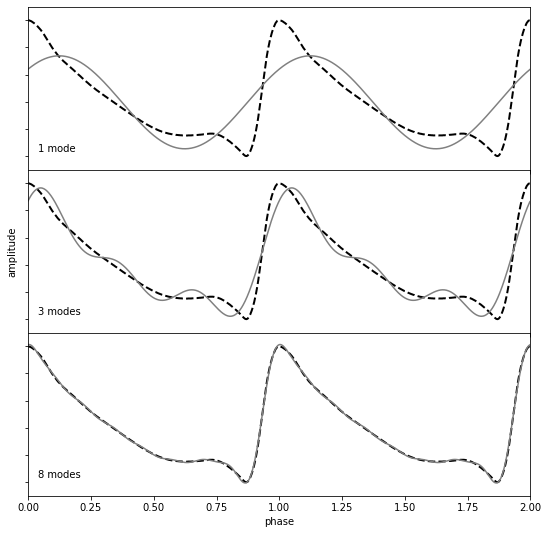

In [33]:
fig_10_1()

The Fourier Transform can be powerful if the signal-to-noise is high. 

But if not, or if the signal has a complex shape or is irregularly sampled, then a probabilistic approach is better.  In astronomy, that is often the situation that we find ourselves in.  So, I'll leave the details of Fourier analysis for you to read about in $\S$ 10.2 and we'll skip ahead.

## Temporally Localized Signals ($\S$ 10.4)

Let's begin with the case of a stationary signal with an event localized in time.
An example would be the signature of a [gravitational wave from LIGO](https://www.ligo.caltech.edu/news/ligo20160615).

In this case we know the expected shape of the signal and the noise properties are understood, so we can do what is called *forward modeling*.  Specifically, we will identify the signal by using a **matched filter** (with MCMC to search for the parameter posteriors).

## Finding a chirp or burst in a time series

Imagine a stationary signal $y(t)=b_0+\epsilon$ with an injected signal at time $T$ (possibly followed by a decay to the original level $b_0$ over some unknown time period).

This injected signal could be a "burst"

$$y(t)=b_0 + A\exp[−\alpha(t−T)]$$

(your last homework!) or a ["chirp"](https://en.wikipedia.org/wiki/Chirp)

$$y(t)=b_0+A \sin[\omega t+\beta t^2].$$

Below is an example of using MCMC to fit a chirp signal.

In [34]:
# A utility function to convert the traces (chains) to a Pandas DataFrame
import pandas as pd
def traces_to_pandas(traces):
    varnames = [ var for var in traces.varnames if not var.endswith("_interval__") ]
    cols = { var: traces[var] for var in varnames }
    return pd.DataFrame(cols)

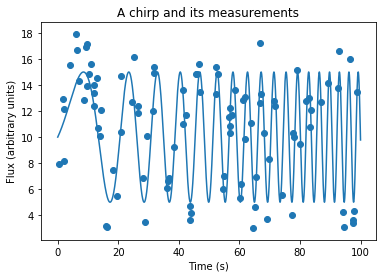

In [35]:
# Ivezic, Figure 10.26
import numpy as np
from matplotlib import pyplot as plt

# Hack to fix import issue in older versions of pymc
import scipy
import scipy.misc
import pymc3 as pm

from astroML.plotting.mcmc import plot_mcmc

#----------------------------------------------------------------------
# Set up toy dataset
def chirp(t, b0, beta, A, omega):
    return b0 + A * np.sin(omega * t + beta * t * t)

np.random.seed(0)

# Change these parameters to see what effect they have on how
# well the system can be modeled.
N = 100
b0_true = 10
A_true = 5
beta_true = 0.01
omega_true = 0.1
sigma = 2.0

# Plot the functional form
t_tmp = np.linspace(0, 100, 10000)
y_tmp = chirp(t_tmp, b0_true, beta_true, A_true, omega_true)
plt.plot(t_tmp, y_tmp)

# Generate the dataset, and overplot
t = np.sort(100 * np.random.random(N))
y_true = chirp(t, b0_true, beta_true, A_true, omega_true)
y_obs = np.random.normal(y_true, sigma)
plt.scatter(t, y_obs)
plt.xlabel("Time (s)")
plt.ylabel("Flux (arbitrary units)")
plt.title("A chirp and its measurements")
None;

In [36]:
# ----------------------------------------------------------------------
# Set up MCMC sampling
with pm.Model():
    b0 = pm.Uniform('b0', 0, 50, testval=50 * np.random.random())
    A = pm.Uniform('A', 0, 50, testval=50 * np.random.random())
    log_beta = pm.Uniform('log_beta', -10, 10, testval=-4.6)
    log_omega = pm.Uniform('log_omega', -10, 10, testval=-2.3)

    y = pm.Normal('y', mu=chirp(t, b0, np.exp(log_beta), A, np.exp(log_omega)),
                  sd=sigma, observed=y_obs)

    # Choose the Metropolis-Hastings step rather than rely on the default
    step = pm.Metropolis()
    traces = pm.sample(draws=5000, tune=2000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [log_omega]
>Metropolis: [log_beta]
>Metropolis: [A]
>Metropolis: [b0]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:12<00:00, 2163.55draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


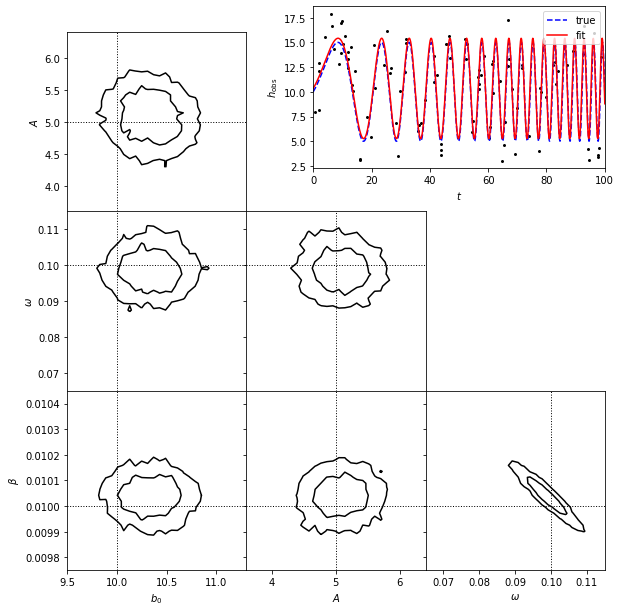

In [37]:
# summarize the results
df = traces_to_pandas(traces)
df["omega"] = np.exp(df['log_omega'])
df["beta"] = np.exp(df['log_beta'])
del df["log_beta"]
del df["log_omega"]

labels = ['$b_0$', '$A$', r'$\omega$', r'$\beta$']
limits = [(9.5, 11.3), (3.6, 6.4), (0.065, 0.115), (0.00975, 0.01045)]
true = [b0_true, A_true, omega_true, beta_true]

fig = plt.figure(figsize=(9, 9))
ax = plt.axes([0.5, 0.7, 0.45, 0.25])

# ----------------------------------------------------------------------
# Plot multiple panels with the traces
plt.scatter(t, y_obs, s=9, lw=0, c='k')

t_tmp = np.linspace(0, 100, 1001)
ax.plot(t_tmp, chirp(t_tmp, b0_true, beta_true, A_true, omega_true), '--', c='blue', label='true')
ax.plot(t_tmp, chirp(t_fit, **df.median()), '-k', c='red', label='fit')
ax.legend()

plt.xlim(0, 100)
plt.xlabel('$t$')
plt.ylabel(r'$h_{\rm obs}$')

plot_mcmc([traces[ii] for ii in ['b0', 'A']]
          + [np.exp(traces['log_omega']), np.exp(traces['log_beta'])],
          labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, bounds=[0.12, 0.08, 0.95, 0.91], colors='k')
plt.show()

## Periodic signals ($\S$ 10.3)

Many systems have **periodic** signals.  This is especially true in astronomy (e.g., RR-Lyrae, Cepheids, eclipsing binaries).

What we want to be able to do is to detect variability and measure the period in the face of both noisy and incomplete data.

For example, the figure on the left is the kind of data that you *want* to have, whereas the figure on the right is the kind of data that you are more likely to have.
<img src="figures/rrlyrae-good.png" style="float: left; width: 40%; margin-right: 1%;"> <img src="figures/rrlyrae-bad.png" style="float: left; width: 40%; margin-right: 1%;">

For a periodic signal we have:

$$y(t+P)=y(t),$$ where $P$ is the period.

We can create a *phased light curve* that plots the data as function of phase:

$$\phi=\frac{t}{P} − {\rm int}\left(\frac{t}{P}\right),$$

where ${\rm int}(x)$ returns the integer part of $x$.

For example in the case below, when the pattern starts to repeat, we reset the $t$ axis to 0:
![Eclipsing Binary](figures/588733main_binary-stars-lightcurve.JPG)

### A Single Sinusoid

Let's take the case where the data are drawn from a single sinusoidal signal:

$$y(t)=A \sin(\omega t+\phi)+\epsilon$$

, determine whether or not the data are indeed consistent with periodic variability and, if so, what is the period.

We can use trig identies to rewrite the model as

$$y(t)=a \sin(\omega t)+b \cos(\omega t),$$

where $A=(a^2+b^2)^{1/2}$ and $\phi=\tan^{−1}(b/a)$.

The model is now linear with respect to coefficients $a$ and $b$ (and nonlinear only with respect to frequency, $\omega$).  We now seek to determine the values of those parameters.


### The Likelihood and the Posterior

Assuming homoscedastic Gaussian errors the likelihood for this model becomes,

$$L\equiv p({t,y}|\omega,a,b,\sigma)=\prod^N_{j=1}\frac{1}{\sqrt{2π}\sigma} \exp \left(\frac{−[y_j−a \sin(\omega t_j)−b \cos(\omega t_j)]^2}{2\sigma^2} \right). $$

where $y_i$ is the measurement (e.g., the brightness of a star) taken at time $t_i$.

Assuming uniform priors on $a, b, \omega$, and $\sigma$ (which gives nonuniform priors on $A$ and $\phi$!) the posterior can be written as

$$p(\omega,a,b,\sigma|{t,y}) \propto \sigma^{−N} \exp \left(\frac{−NQ}{2\sigma^2} \right).$$

The posterior:

$$p(\omega,a,b,\sigma|{t,y}) \propto \sigma^{−N} \exp \left(\frac{−NQ}{2\sigma^2} \right).$$

where

>$Q= V - {2\over N} \left[ a \, I(\omega) + b \, R(\omega) - a\, b\, M(\omega) - {1 \over 2} a^2 \, S(\omega) - {1 \over 2} b^2 \,C(\omega)\right]$

and

>$            V = {1\over N} \sum_{j=1}^N y_j^2$

>$       I(\omega) = \sum_{j=1}^N y_j   \sin(\omega t_j)$

>$ R(\omega) = \sum_{j=1}^N y_j  \cos(\omega t_j)$

>$      M(\omega) = \sum_{j=1}^N \sin(\omega t_j) \, \cos(\omega t_j)$

>$      S(\omega) = \sum_{j=1}^N \sin^2(\omega t_j)$

>$C(\omega) = \sum_{j=1}^N  \cos^2(\omega t_j)$

*NOTE* I, R, M, S, C only depend on $\omega$ and not the data.

### Done (?)

At this point, we could simply apply the sampling machinery to estimate the posteriors for all the parameters.

However, we'd quickly run into two problems:
1. The posterior hyper-surfaces for these types of problems have many "hills and valleys"; they're not easy to sample from (and sometimes the sampler may even get "stuck" around a wrong solution).
1. The sampling is slow; in modern surveys we'll have billions of objects to assess.

### Approximations: The posterior for many, randomly spaced, observations

If $N \gg 1$ and we have data that extends longer than the period and hasn't been taken at special times, we have:

$S(\omega) \approx C(\omega) \approx N/2$ and $M(\omega) \ll N/2$ and

>$Q \approx V - {2\over N} \left[ a \, I(\omega) + b \, R(\omega)\right]  + {1 \over 2} (a^2 + b^2)$

If we marginalize over $a$ and $b$ (as we are interested in the period)

>$  p(\omega,\sigma|\{t,y\}) \propto  \sigma^{-(N-2)} \exp \left( { - N V \over 2 \sigma^2} + { P(\omega) \over \sigma^2}       \right)$

with $P(\omega) = {1 \over N} [ I^2(\omega) + R^2(\omega)]$

if we know the noise $\sigma$ then 

>$   p(\omega|\{t,y\}, \sigma) \propto \exp \left( { P(\omega) \over \sigma^2} \right)$

and we now have the posterior for $\omega$!

The simplified posterior for $\omega$ comes out to be

$$ p(\omega|\{t,y\}, \sigma) \propto \exp \left(\frac{P(\omega)}{\sigma^2} \right),$$

where

$$P(\omega) = {1 \over N} [ I^2(\omega) + R^2(\omega)]$$

$$ I(\omega) = \sum_{j=1}^N y_j   \sin(\omega t_j), \; \; \; R(\omega) = \sum_{j=1}^N y_j  \cos(\omega t_j)$$

is the [periodogram](https://en.wikipedia.org/wiki/Periodogram), which is just a plot of the "power" at each possible period (as illustrated below):

<img src="figures/periodogram.png">

### Significance of the peaks in the periodogram

Similarly, we can derive an expression for $\chi^2$.

The $\chi^2$ is given by:

$$\chi^2(\omega) \equiv {1 \over \sigma^2} \sum_{j=1}^N [y_j-y(t_j)]^2 =
  {1 \over \sigma^2} \sum_{j=1}^N [y_j- a_0\, \sin(\omega t_j) - b_0 \, \cos(\omega t_j)]^2,$$
  
which we can simplify (see the textbook) to:

$$\chi^2(\omega) =  \chi_0^2 \, \left[1 - {2 \over N \, V}  \, P(\omega) \right],$$

where, $P(\omega)$ is the periodogram we defined above and $\chi_0^2$ is the $\chi^2$ for a model with $y(t)$=constant:

$$  \chi_0^2 = {1 \over \sigma^2} \sum_{j=1}^N y_j^2 = {N \, V \over \sigma^2}$$

We'll now renormalise the periodogram, defining the [Lomb-Scargle periodogram](https://en.wikipedia.org/wiki/Least-squares_spectral_analysis#The_Lomb.E2.80.93Scargle_periodogram) as

$$P_{\rm LS}(\omega) = \frac{2}{N V} P(\omega),$$

One can show that $0 \le P_{\rm LS}(\omega) \le 1$.

To determine if our source is variable or not, we first compute $P_{\rm LS}(\omega)$ and then model the odds ratio for our variability model vs. a no-variability model.

If our variability model is "correct", then the peak of $P(\omega)$ [found by grid search] gives the best $\omega$ and the $\chi^2$ at $\omega = \omega_0$ is $N$.

If the true frequency is $\omega_0$ then the maximum peak in the periodogram should have a height

$$P(\omega_0) = {N \over 4} (a_0^2 + b_0^2)$$

and standard deviation
$$      \sigma_P(\omega_0)  = {\sqrt{2} \over 2} \, \sigma^2.$$

### Properties of LS and the periodogram

Some properties of Lomb-Scargle and the periodogram:
- The expected heights of the peaks in a periodogram don't depend on $\sigma$ but their width does.
- For $P_{\rm LS}(\omega_0)$, with no noise the peak approaches 1. As noise increases, $P_{\rm LS}(\omega_0)$ decreases and is ``buried'' in the background  noise.

### Example

Below is an example of a LS periodogram generated using 100 points drawn from $y(t|P) = 10 + \sin(2\pi t/P),$ with $P=0.3$.  

[http://www.astroml.org/gatspy/periodic/lomb_scargle.html](http://www.astroml.org/gatspy/periodic/lomb_scargle.html) gives more information on astroML's implementation.

        Use astropy.stats.LombScargle instead. [warnings]
        Use astropy.stats.LombScargle.false_alarm_probability instead. [warnings]
        Use astropy.stats.LombScargle instead. [astroML.time_series.periodogram]


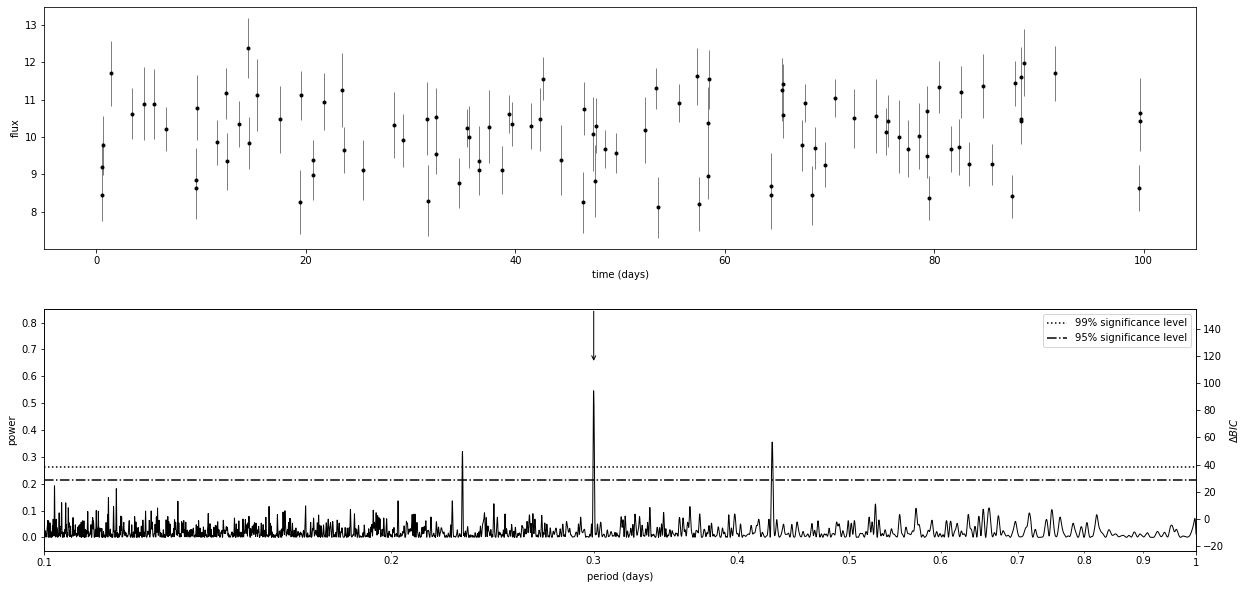

In [41]:
# Similar to Figure 10.15
# Author: Jake VanderPlas
# License: BSD
from matplotlib import pyplot as plt
from astroML.time_series import\
    lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap

#------------------------------------------------------------
# Generate Data
np.random.seed(0)
N = 100
P = 0.3

t = np.random.randint(100, size=N) + 0.3 + 0.4 * np.random.random(N)
y = 10 + np.sin(2 * np.pi * t / P)
dy = 0.5 + 0.5 * np.random.random(N)
y_obs = np.random.normal(y, dy)

#------------------------------------------------------------
# Compute periodogram
period = 10 ** np.linspace(-1, 0, 10000)
omega = 2 * np.pi / period
PS = lomb_scargle(t, y_obs, dy, omega, generalized=True)

#------------------------------------------------------------
# Get significance via bootstrap
D = lomb_scargle_bootstrap(t, y_obs, dy, omega, generalized=True,
                           N_bootstraps=500, random_state=0)
sig1, sig5 = np.percentile(D, [99, 95])

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(left=0.1, right=0.9, hspace=0.25)

# First panel: the data
ax = fig.add_subplot(211)
ax.errorbar(t, y_obs, dy, fmt='.k', lw=1, ecolor='gray')
ax.set_xlabel('time (days)')
ax.set_ylabel('flux')
ax.set_xlim(-5, 105)

# Second panel: the periodogram & significance levels
ax1 = fig.add_subplot(212, xscale='log')
ax1.plot(period, PS, '-', c='black', lw=1, zorder=1)
ax1.plot([period[0], period[-1]], [sig1, sig1], ':', c='black', label="99% significance level")
ax1.plot([period[0], period[-1]], [sig5, sig5], '-.', c='black', label="95% significance level")
ax1.legend()

ax1.annotate("", (0.3, 0.65), (0.3, 0.85), ha='center',
             arrowprops=dict(arrowstyle='->'))

ax1.set_xlim(period[0], period[-1])
ax1.set_ylim(-0.05, 0.85)

ax1.set_xlabel(r'period (days)')
ax1.set_ylabel('power')

# Twin axis: label BIC on the right side
ax2 = ax1.twinx()
ax2.set_ylim(tuple(lomb_scargle_BIC(ax1.get_ylim(), y_obs, dy)))
ax2.set_ylabel(r'$\Delta BIC$')

ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_minor_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_major_locator(plt.LogLocator(10))
ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3g'))

plt.show()

If that isn't impressive, try changing the period to 5-10 days and the number of points to 200-300 (you'll need to increase `period` as appropriate) to compare this to a situation that is more obvious.

### Non-sinusoidal signals

We've derived and discussed LS periodogram by looking at sinusoidal variation; real objects' light curve shapes are frequently more complex than sinusoids.

Even so, **LS remains an efficient technique to find the period of variability**, as long as the object varies with a well-defined period. The highest peak (most of the times) gives the variability period.

Process:
1. Obtain the data, ensure they satisfy the assumptions under which LS has been derived (N $\gtrsim$ 20 data points, randomly distributed, over many periods)
2. Compute the LS periodogram
3. Find the highest peak
4. Fold the light curve to study its shape, amplitude, etc.

## Generalizations

### Generalized Lomb-Scargle

The Lomb-Scargle periodogram is a fit to a model:

$$y(t)=a \sin(\omega t)+b \cos(\omega t),$$

whose mean is zero. In reality, the observed variability is typically around some (mean) value, not zero. We deal with this by subtracting the mean of the sample $\overline{y}$ from the data before performing the periodogram analysis.

That only works if $\overline{y}$ is a good estimator of the mean of the distribution, $y(t)$ -- if the data is equally sampled at all phases. However, in practice, the data may not equally sample all of the phases.

For example, consider the case of a star that has a period of one day and the fact that a single optical telescope only takes data at night. In that case you we might get something like the top panel below:

![Ivezic, Figure 10.16](http://www.astroml.org/_images/fig_LS_sg_comparison_3.png)

The "generalized" Lomb-Scargle approach (also implemented in astroML) can help with this as can be seen in the bottom panel above. It fits the model with non-zero mean:

$$y(t)=a \sin(\omega t)+b \cos(\omega t) + C$$

See also [Figure 10.16](http://www.astroml.org/book_figures/chapter10/fig_LS_sg_comparison.html) in the textbook.

### Multiband LS periodograms

One of the issues that we are going to be dealing with in astronomy over the next decade as the LSST project comes online is the problem of sparsely-sampled light curves, but with multiple light curves for each object -- one for each "bandpass" as seen below:

<img src="figures/multibandLS.png" style="float: right; width: 100%; margin-right: 1%;">



The generalized LS was an extension to account for the mean value. We can build on this to account for multiple bands by fitting for a global period, global mean, and a per-band offsets.

$$\begin{eqnarray}
  &y_k(t|\omega,\theta) =
  \theta_0 + \sum_{n=1}^{N_{base}} \left[\theta_{2n - 1}\sin(n\omega t) + \theta_{2n}\cos(n\omega t)\right] +&\nonumber
  &\theta^{(k)}_0 + \sum_{n=1}^{N_{band}} \left[\theta^{(k)}_{2n - 1}\sin(n\omega t) + \theta^{(k)}_{2n}\cos(n\omega t)\right].&
\end{eqnarray}$$

The total number of parameters for $K$ filters is then $M_K = (2N_{base} + 1) + K(2N_{band} + 1)$. 

The important feature of this model is that _all bands_ share the same base parameters, $\theta$, while their offsets $\theta^{(k)}$ are determined individually.

Below we show the multi-band light curves of an RR Lyrae star as an example.  

A fit with just one base term isn't so great:

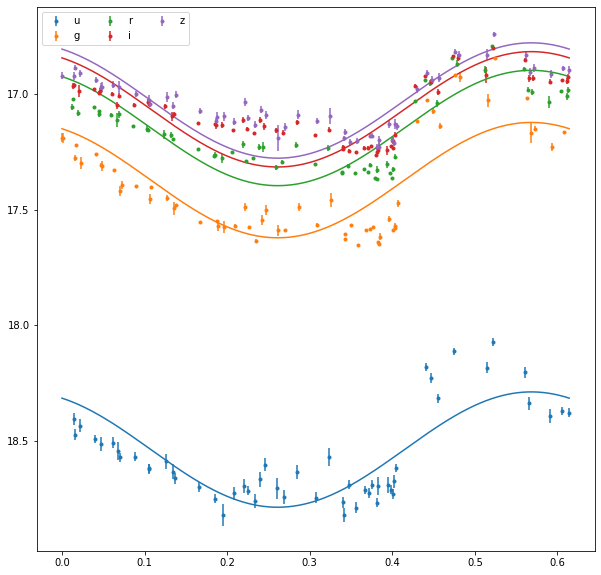

In [28]:
from gatspy.datasets import fetch_rrlyrae

# Patch for changed URL
import gatspy.datasets.rrlyrae
gatspy.datasets.rrlyrae.SESAR_RRLYRAE_URL = 'https://github.com/astroML/astroML-data/raw/master/datasets/S82_RRLyr/'

rrlyrae = fetch_rrlyrae()
lcid = rrlyrae.ids[0]

t, y, dy, filts = rrlyrae.get_lightcurve(lcid)
period = rrlyrae.get_metadata(lcid)['P']

from gatspy.periodic import LombScargleMultiband
model = LombScargleMultiband(Nterms_base=1, Nterms_band=0)
model.fit(t, y, dy, filts)
periods = np.linspace(period - 0.1, period + 0.1, 2000)
power = model.periodogram(periods)

def plot_model(model, lcid):
    t, y, dy, filts = rrlyrae.get_lightcurve(lcid)
    model.fit(t, y, dy, filts)
    
    tfit = np.linspace(0, period, 1000)
    for filt in 'ugriz':
        mask = (filts == filt)
        eb = plt.errorbar(t[mask] % period, y[mask], dy[mask], fmt='.', label=filt)
        yfit = model.predict(tfit, filt, period=period)
        plt.plot(tfit, yfit, color=eb[0].get_color())
    plt.gca().invert_yaxis()
    plt.legend(ncol=3, loc='upper left')
    
fig = plt.figure(figsize=(10,10))
plot_model(LombScargleMultiband(Nterms_base=1, Nterms_band=0), lcid)

But with 4 base terms, we get excellent results.  Note that this works well for this case where we don't expect $\omega$ to be bandpass dependent (it might not work so well for quasars).

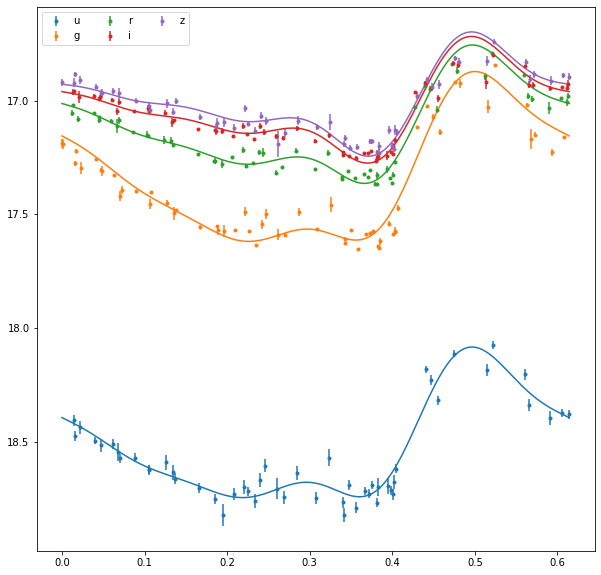

In [29]:
fig = plt.figure(figsize=(10,10))
plot_model(LombScargleMultiband(Nterms_base=4, Nterms_band=1), lcid)

### Classification

With parameters of a periodic model in hand, we can attempt to classify our sources.  Either using supervised methods if we have labeled examples or unsupervised methods if we do not.

The examples below show that a sample of variable stars can be divided into different groups.  The first plot shows an unsupervised clustering analysis and the second is a supervised GMMB classification.

We will learn more about this when we discuss machine learning.

![Ivezic, Figure 10.20](http://www.astroml.org/_images/fig_LINEAR_clustering_1.png)

![Ivezic, Figure 10.22](http://www.astroml.org/_images/fig_LINEAR_GMMBayes_1.png)

## Summary

Today we've learned about **time series**, and techniques for estimation of parameters of time-varying objects. We've looked at:

* How to decide if an object is variable (via $\chi^2$)
* How to estimate parameters of temporally localized signals (matched filter; standard model fitting techniques)
* Approximate methods for finding periods in periodic signals (periodograms)
* How to interpret periodograms
* Some periodogram generalizations

All these techniques give us estimates of parameter values (periods, amplitudes, light curve shape parameters, etc) for an object. When applied to thousands or millions of objects, we may begin to notice some similarities -- families of objects with similar periods, amplitudes of variability, colors, and so on. These similarities may indicate the same physics governs the variability in all these objects.

In the lectures to follow, we will look at techniques for identification of such similarity, leading us to topics of clustering, classification, and machine learning.